# Loading Libraries

Bse libraries and current path

In [1]:
import os
print(os.getcwd())

C:\Users\mauricio\Desktop\PruebaTecnicaWandJ


Third party libraries

In [2]:
import numpy as np
import pandas as pd
import altair as alt
import matplotlib.pyplot as plt
from joblib import load, dump

import nltk
#nltk.download('punkt') # download punkt in order to use word tokenizer
#nltk.download('stopwords') # download stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB 
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix, classification_report

Code flow flags

In [3]:
create_ETL_data = False

# ETL

In [60]:
df_org = pd.read_json('Data/News_Category_Dataset_v2.json',lines=True)
# Rename index as id since it will help to build the data after token explotion
df_org.index.rename('id',inplace= True)
df_org

,category,headline,authors,link,short_description,date
id,,,,,,
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26
...,...,...,...,...,...,...
200848,TECH,RIM CEO Thorsten Heins' 'Significant' Plans Fo...,"Reuters, Reuters",https://www.huffingtonpost.com/entry/rim-ceo-t...,Verizon Wireless and AT&T are already promotin...,2012-01-28
200849,SPORTS,Maria Sharapova Stunned By Victoria Azarenka I...,,https://www.huffingtonpost.com/entry/maria-sha...,"Afterward, Azarenka, more effusive with the pr...",2012-01-28
200850,SPORTS,"Giants Over Patriots, Jets Over Colts Among M...",,https://www.huffingtonpost.com/entry/super-bow...,"Leading up to Super Bowl XLVI, the most talked...",2012-01-28


In [5]:
alt.Chart(df_org['category']
              .value_counts()
              .reset_index()
              .rename(columns={'category':'freq',
                               'index':'category'})
).mark_bar().encode(
    y='freq:Q',
    x=alt.X('category:N', sort='-y'),
    tooltip=['category','freq']
).properties(
    title='[Interactive] Articles by Category'
)

alt.Chart(...)

Now let's look at the cumulative percentual sum of categories in order to understand how many categories acumulate more than 50%

In [6]:
(df_org[["category", "headline"]].category.value_counts().cumsum()/200853).head(10)

POLITICS          0.163000
WELLNESS          0.251756
ENTERTAINMENT     0.331705
TRAVEL            0.380930
STYLE & BEAUTY    0.428970
PARENTING         0.472171
HEALTHY LIVING    0.505499
QUEER VOICES      0.536935
FOOD & DRINK      0.567933
BUSINESS          0.597492
Name: category, dtype: float64

First 7 categories sum up more than 50% of the articles. Nevertheless, it seems like some categories could be kind of ambiguos, categories like: "PARENTING" and "PARENTS", "THE WORDPOST" and "WORLDPOST", "ARTS", "ARTS AND CULTURE" and "CULTURE ARTS, "EDUCATION" and "COLLEGE", "STYLE AND BEAUTY" and "STYLE". It is possible that differences between these categories could be very small.

## Sample Data for ETL

Let's use some of the data in order to develop the ETL and then apply it to all data.

In [7]:
df = df_org.sample(frac = 0.1, random_state=1)

## Tokenization, Stopwords and Stemming 

In [8]:
def tokenization_stopwords_stemming(df, col_name='headline', tok_col_name='tok'):
    """
    Function that, given a pandas dataframe, a text column name and token column name,
    applies tokenization, stopwords(english) and stemming(english).
    Returns dataframe with column tok_col_name added
    """
    # Tokenization
    df[tok_col_name] = df[col_name].apply(word_tokenize)
    df_tok = df.explode(tok_col_name)
    
    # Convert tokens to lower case
    df_tok.loc[:,[tok_col_name]] = df_tok.apply(lambda x: str(x[tok_col_name]).lower(), axis = 1)
    
    # Get stopwords
    stop_words = [x for x in nltk.corpus.stopwords.words('english')]
    # Add some custom punctation (some punctation could be usefull)
    stop_words.extend(['-','(',')','.',':',',',"'","'s",'?',"n't","’","_"])
    
    # Clean stopwords and some punctuation
    df_tok.loc[:,['in_stopwords']] = df_tok.apply(lambda x: x[tok_col_name] in stop_words, axis = 1)
    df_tok_clean = df_tok[~df_tok['in_stopwords']]
    
    # Apply Snowball stemmer
    stemmer = nltk.stem.SnowballStemmer('english')
    df_tok_clean.loc[:,[tok_col_name]] = df_tok_clean[tok_col_name].astype(str)
    df_tok_clean.loc[:,[tok_col_name]] = df_tok_clean.apply(lambda x: stemmer.stem(x[tok_col_name]), axis = 1)
    
    return(df_tok_clean)
    

In [9]:
df_tok_clean = tokenization_stopwords_stemming(df)

c:\users\mauricio\appdata\local\programs\python\python37\lib\site-packages\pandas\core\indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


## Plot Word by Category

In [10]:
def plot_freq_x_context(df_tok_clean, class_col_name='category', tok_col_name='tok', n=5):
    """
    Function that, given a pandas dataframe, a text column name and token column name,
    plots the n largest frequency tokens by class_col_name.
    Returns altair chart
    """
    # Group tokens by class_col_name and tokname
    grouped_toks = (df_tok_clean
                        .reset_index()
                        .filter(['id',class_col_name,tok_col_name], axis=1)
                        .groupby([class_col_name,tok_col_name])
                        .agg({'id':['count']})
                        .sort_values([class_col_name,('id', 'count')], ascending = False)
    )
    grouped_toks.columns = grouped_toks.columns.map('_'.join)
    grouped_toks = grouped_toks.rename(columns = {'id_count':'count'}).reset_index()
    
    # Return altair facet graph
    return(alt.Chart(grouped_toks
                  .groupby(class_col_name)
                  .head(n)
    ).mark_bar().encode(
        x='count:Q',
        y=alt.Y(tok_col_name + ':N', sort='-x'),
        tooltip=[tok_col_name,'count']
    ).properties(
        width=120,
        height=50
    ).facet(
        facet= class_col_name + ':N',
        columns=4
    ).resolve_scale(
      x='independent',
      y='independent'
    ))
    
plot_freq_x_context(df_tok_clean)

alt.FacetChart(...)

Looking at the most common words by category, one can see that the difference between some categories could be really small. For example: "ARTS & CULTURE", "ARTS" and "CULTURE & ARTS" have large frequency in words like "art" y "artist". As well, we can see that the words "Trump" is common to many categories and not only "POLITICS". It is possible that using  ngrams could be usefull for discrminating among categories.

## Liquid Text Creation 

In [11]:
def to_liquid_text(df_tok_clean, class_col_name='category', tok_col_name='tok'):
    """
    Function that, given a pandas dataframe, a class_col_name and tok_col_name,
    joins the column tok_col_name with a space for each "id" in order to form a liquid text column.
    Returns dataframe with column 'text' added
    """
    return(df_tok_clean
               .reset_index()
               .filter(['id',class_col_name,tok_col_name], axis=1)
               .groupby(['id',class_col_name])[tok_col_name]
               .apply(' '.join)
               .reset_index()
               .rename(columns = {tok_col_name:'text'}))

In [12]:
df_liquid_text = to_liquid_text(df_tok_clean)
df_liquid_text.head()

,id,category,text
0,24,WORLD NEWS,2 men deton bomb insid indian restaur near tor...
1,38,COMEDY,seth meyer 1 funni regret trump cancel north k...
2,53,ENTERTAINMENT,harvey weinstein accus say never thought would...
3,56,ENTERTAINMENT,boba fett get star war movi
4,62,POLITICS,member far-right proud boy menac twitter user ...


These examples seem to show that the ETL is working well. The longest part of the process is  the "tokenization_stopwords_stemming" function that took 38 seconds for 20k rows.

## ETL a todos los datos

In [13]:
def ETL(df, col_name= 'headline', class_col_name='category', tok_col_name='tok'):
    # Primer paso: Tokenizacion, stopwords y stemming
    df_tok_clean = tokenization_stopwords_stemming(df, col_name=col_name, tok_col_name=tok_col_name)
    
    # Segundo paso: Crear texto liquido del dataframe limpio
    df_liquid_text = to_liquid_text(df_tok_clean, class_col_name=class_col_name, tok_col_name=tok_col_name)
    
    return df_tok_clean,df_liquid_text

Apply ETL on "headline" column.

In [14]:
if create_ETL_data: 
    df_tok_clean_headlines,df_liquid_text_headlines = ETL(df_org)
    df_tok_clean_headlines.to_pickle('./Data/clean_data_headlines.pkl')
    df_liquid_text_headlines.to_pickle('./Data/clean_liquidtext_headlines.pkl')

Do the same for the combination of columns "headline"+"short_description"

In [15]:
if create_ETL_data: 
    df_hd = df_org
    df_hd['headline_description'] = df_hd['headline'] + ' ' + df_hd['short_description']
    df_clean_headline_short_description,df_liquid_text_headline_short_description = ETL(df_hd, col_name='headline_description')
    df_clean_headline_short_description.to_pickle('./Data/clean_data_headline_short_description.pkl')
    df_liquid_text_headline_short_description.to_pickle('./Data/clean_liquidtext_headline_short_description.pkl')

# Models

## Data Split

Let's make a division between a training set and a test set using the column "id" so that we can fairly compare all proposed models.

In [16]:
train_idx, test_idx = train_test_split(range(len(df_org)), test_size=0.1, random_state=42, shuffle=True)
print(f"Number of training: {len(train_idx)}, Number of testing: {len(test_idx)}")

Number of training: 180767, Number of testing: 20086


## Only Headlines NB (Naive Bayes)

In [17]:
model_name = 'headlines_NB'
model_description = 'Naive Bayes Model on headlines only'
filename = f"./Data/model_{model_name}.joblib"

In [18]:
df_liquid_text = pd.read_pickle('./Data/clean_liquidtext_headlines.pkl')
len(df_liquid_text.id)

200807

Apply training-test separation using indices

In [19]:
train = df_liquid_text[df_liquid_text.id.isin(train_idx)]
test = df_liquid_text[df_liquid_text.id.isin(test_idx)]
print(train.shape)
print(test.shape)

(180725, 3)
(20082, 3)


In [20]:
text_clf_CV = Pipeline([('vect', CountVectorizer()),
                      ('tfidf', TfidfTransformer()),
                      ('clf', MultinomialNB()),
                    ])
param_grid = {
    'vect__max_features': [500,1000,5000,10000],
    'tfidf__use_idf': (True, False)
}

In [21]:
if os.path.exists(filename):
    model_data = load(filename)
    search = model_data['model_CV']
else:
    search = GridSearchCV(text_clf_CV, param_grid, n_jobs=2)
    search.fit(train.text, train.category)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Best parameter (CV score=0.479):
{'tfidf__use_idf': True, 'vect__max_features': 5000}


In [22]:
def GridSearchResultToDF(search):
    """
    Function that extracts the results from GridSearchCV and
    converts them to a pandas dataframe
    """
    return(pd.concat([pd.DataFrame(data = search.cv_results_['params']),
                      pd.DataFrame(data = {'mean': search.cv_results_['mean_test_score'],
                                           'std': search.cv_results_['std_test_score']})],
                     axis = 1))

def PlotComparison(result_values, descrete, continuous):
    """
    Function that takes the result from GridSearchResultToDF function and
    plots some of their values
    """
    base = alt.Chart(result_values).transform_calculate(
        ymin="datum.mean-2*datum.std",
        ymax="datum.mean+2*datum.std"
    )
    points = base.mark_point(
        filled=True,
        size=10
    ).encode(
        x=continuous,
        y=alt.Y('mean:Q'),#, scale=alt.Scale(domain=(0.55, 0.7))),
        color=descrete,
        tooltip=['mean','std']
    )

    errorbars = base.mark_errorbar().encode(
        x=continuous,
        y="ymin:Q",
        y2="ymax:Q",
        color=descrete,
    )

    return(points + errorbars)

descrete = 'tfidf__use_idf'
continuous = 'vect__max_features'
result_values = GridSearchResultToDF(search)
PlotComparison(result_values, descrete, continuous)

alt.LayerChart(...)

In [23]:
result_values.groupby(['tfidf__use_idf'])['mean'].agg(['mean'])

,mean
tfidf__use_idf,
False,0.432379
True,0.433669


Difference between using/not-using tfidf seems to be very small. This could be due to the fact that most headers have similar lengths.

In [24]:
text_clf = search.best_estimator_.fit(train.text, train.category)
predicted_test = text_clf.predict(test['text'])
np.mean(predicted_test == test.category)

0.5016432626232447

In [25]:
if not os.path.exists(filename):
    model_dict = {
        'model_name': model_name,
        'model_description': model_description,
        'model_CV': search,
        'model_results': pd.concat([test[['id','category']],pd.DataFrame({'pred':predicted_test})])
    }
    dump(model_dict,filename)

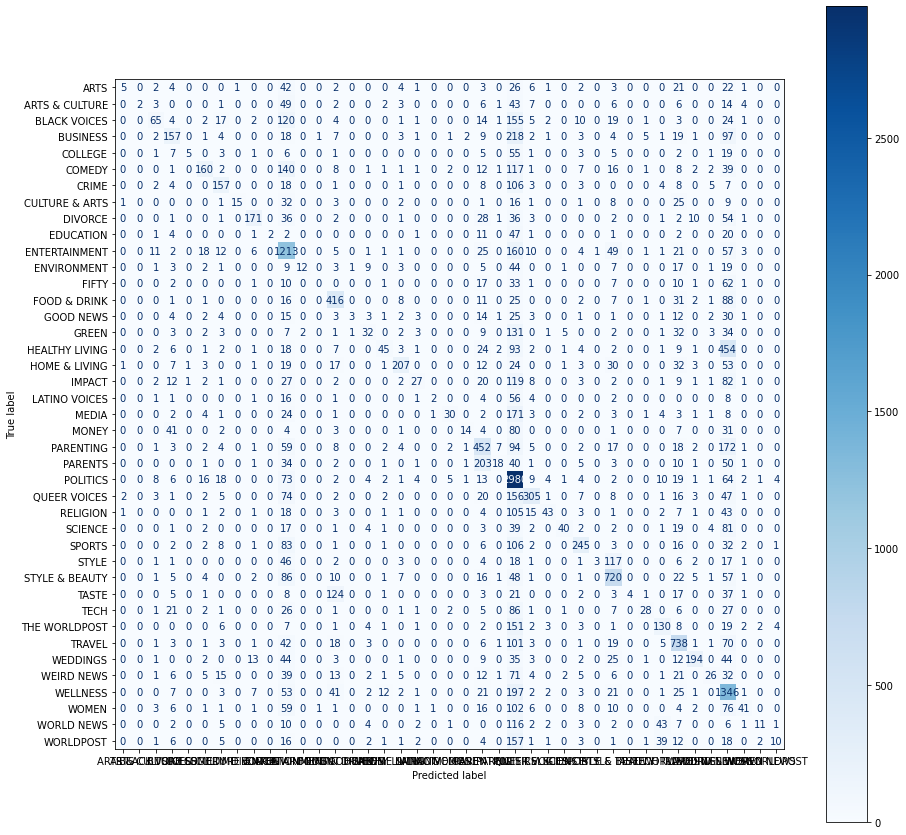

In [26]:
fig, ax = plt.subplots(figsize=(15, 15))
disp = plot_confusion_matrix(text_clf, test['text'], test.category,
                             cmap=plt.cm.Blues,
                             normalize=None,
                             ax = ax)

The most common confusions are:

- Three most common categories get mixed up with the rest of categories.
- "STYLE & BEAUTY" gets mixed up with "STYLE"
- "FOOD & DRINKS" gets mixed up with"TASTE"
- "POLITICS" gets mixed up with "BUSSINESS", "THE WORLDPOST", "ENTERTAIMENT"

Let's investigate some example of errors made by the model. First, let us look at articles which are in the "BUSINESS" category but where predicted as "POLITICS" by our model.

In [27]:
classes = np.sort(df_org.category.unique())
test_probabilities = pd.DataFrame(data = text_clf.predict_proba(test['text']),
                                 index = test['id'],
                                 columns =  classes)
test['predicted'] = predicted_test
test_cols = test.columns
test_merge = test.merge(test_probabilities,'left',on = 'id')
test_case = test_merge[(test_merge['category'] == 'BUSINESS') & (test_merge['predicted'] == 'POLITICS')]
result = test_case[['id','category','text','predicted','POLITICS','BUSINESS']].sort_values('BUSINESS', ascending=False).head()
result

c:\users\mauricio\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,id,category,text,predicted,POLITICS,BUSINESS
5455,54075,BUSINESS,compani forc disclos climat risk unilev ceo say,POLITICS,0.361642,0.359552
5234,52185,BUSINESS,u.s. consum agenc unveil plan toughen regul de...,POLITICS,0.314510,0.286650
16730,166992,BUSINESS,wage recov top one percent stagnat worker,POLITICS,0.316513,0.284904
9284,92371,BUSINESS,fight $ 15 minimum wage,POLITICS,0.431412,0.276424
18985,189642,BUSINESS,corpor raider corpor redeem,POLITICS,0.313636,0.250063


In [28]:
df_org[df_org.index==62215][['headline','short_description']].values

array([['IMF Boss Urges U.S. To Raise The Federal Minimum Wage',
        'Christine Lagarde reckons that higher minimum wages and more family-friendly policies would improve the economy.']],
      dtype=object)

In [29]:
print(classification_report(test.category, predicted_test))

                precision    recall  f1-score   support

          ARTS       0.50      0.03      0.06       146
ARTS & CULTURE       1.00      0.01      0.03       149
  BLACK VOICES       0.57      0.14      0.23       451
      BUSINESS       0.46      0.28      0.35       557
       COLLEGE       0.71      0.04      0.08       115
        COMEDY       0.67      0.31      0.42       523
         CRIME       0.55      0.48      0.51       327
CULTURE & ARTS       0.94      0.13      0.23       115
       DIVORCE       0.80      0.49      0.61       350
     EDUCATION       1.00      0.02      0.04        93
 ENTERTAINMENT       0.46      0.76      0.57      1602
   ENVIRONMENT       0.86      0.09      0.16       138
         FIFTY       0.00      0.00      0.00       146
  FOOD & DRINK       0.58      0.68      0.62       610
     GOOD NEWS       0.60      0.02      0.04       131
         GREEN       0.45      0.12      0.19       274
HEALTHY LIVING       0.57      0.07      0.12  

## Headlines y Description NB

In [30]:
model_name = 'headlines_description_NB'
model_description = 'Naive Bayes Model on headlines and short description'
filename = f"./Data/model_{model_name}.joblib"

In [31]:
df_liquid_text2 = pd.read_pickle('./Data/clean_liquidtext_headline_short_description.pkl')
df_liquid_text2

,id,category,text
0,0,CRIME,2 mass shoot texa last week 1 tv left husband ...
1,1,ENTERTAINMENT,smith join diplo nicki jam 2018 world cup offi...
2,2,ENTERTAINMENT,hugh grant marri first time age 57 actor longt...
3,3,ENTERTAINMENT,jim carrey blast castrato adam schiff democrat...
4,4,ENTERTAINMENT,julianna marguli use donald trump poop bag pic...
...,...,...,...
200843,200848,TECH,rim ceo thorsten hein signific plan blackberri...
200844,200849,SPORTS,maria sharapova stun victoria azarenka austral...
200845,200850,SPORTS,giant patriot jet colt among improb super bowl...
200846,200851,SPORTS,aldon smith arrest 49er lineback bust dui corr...


In [32]:
train = df_liquid_text2[df_liquid_text2.id.isin(train_idx)]
test = df_liquid_text2[df_liquid_text2.id.isin(test_idx)]
print(train.shape)
print(test.shape)

(180762, 3)
(20086, 3)


In [33]:
df_tok_clean = pd.read_pickle('./Data/clean_data_headline_short_description.pkl')
plot_freq_x_context(df_tok_clean)

alt.FacetChart(...)

Separemos una porción de los datos para hacer el entrenamiento y una porción para hacer el test

In [34]:
if os.path.exists(filename):
    model_data = load(filename)
    search = model_data['model_CV']
else:
    search = GridSearchCV(text_clf_CV, param_grid, n_jobs=2)
    search.fit(train.text, train.category)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Best parameter (CV score=0.506):
{'tfidf__use_idf': True, 'vect__max_features': 5000}


In [35]:
descrete = 'tfidf__use_idf'
continuous = 'vect__max_features'
result_values = GridSearchResultToDF(search)
PlotComparison(result_values, descrete, continuous)

alt.LayerChart(...)

In [36]:
result_values.groupby(['tfidf__use_idf'])['mean'].agg(['mean'])

,mean
tfidf__use_idf,
False,0.452294
True,0.458126


In [37]:
text_clf = search.best_estimator_.fit(train['text'], train.category)
predicted_test = text_clf.predict(test['text'])
np.mean(predicted_test == test.category)

0.5291745494374192

In [38]:
if not os.path.exists(filename):
    model_dict = {
        'model_name': model_name,
        'model_description': model_description,
        'model_CV': search,
        'model_results': pd.concat([test[['id','category']],pd.DataFrame({'pred':predicted_test})])
    }
    dump(model_dict,filename)

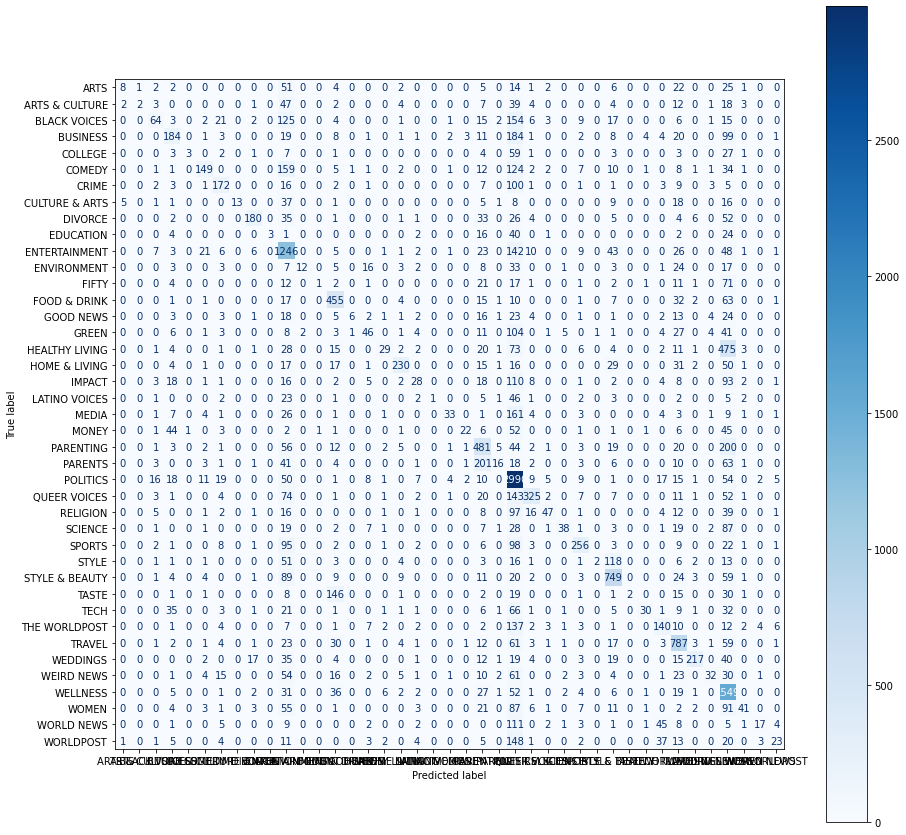

In [39]:
fig, ax = plt.subplots(figsize=(15, 15))
disp = plot_confusion_matrix(text_clf, test['text'], test.category,
                             cmap=plt.cm.Blues,
                             normalize=None,
                             ax = ax)

In [40]:
print(classification_report(test.category, predicted_test))

                precision    recall  f1-score   support

          ARTS       0.50      0.05      0.10       146
ARTS & CULTURE       0.67      0.01      0.03       149
  BLACK VOICES       0.52      0.14      0.22       451
      BUSINESS       0.48      0.33      0.39       557
       COLLEGE       0.75      0.03      0.05       115
        COMEDY       0.69      0.28      0.40       523
         CRIME       0.59      0.53      0.55       327
CULTURE & ARTS       1.00      0.11      0.20       115
       DIVORCE       0.82      0.51      0.63       350
     EDUCATION       1.00      0.03      0.06        93
 ENTERTAINMENT       0.47      0.78      0.58      1602
   ENVIRONMENT       0.86      0.09      0.16       138
         FIFTY       0.50      0.01      0.01       146
  FOOD & DRINK       0.56      0.75      0.64       610
     GOOD NEWS       0.75      0.05      0.09       131
         GREEN       0.44      0.17      0.24       274
HEALTHY LIVING       0.58      0.04      0.08  

## Recortando categorias NB

In [50]:
model_name = 'headlines_description_7_categories_NB'
model_description = 'Naive Bayes Model on headlines and short description and only taking 7 classes'
filename = f"./Data/model_{model_name}.joblib"

Recortemos las categorias para incluir más del 50%. Inicialmente, combinemos la categoria "PARENTS" a "PARENTING"

In [51]:
df_liquid_text2 = pd.read_pickle('./Data/clean_liquidtext_headline_short_description.pkl')
df_liquid_text2.loc[df_liquid_text2['category']=='PARENTS','category'] = 'PARENTING'

Luego, el resto de categorias llevemoslas a una nueva categoria llamada "OTHER"

In [52]:
to_other = ['QUEER VOICES','FOOD & DRINK','BUSINESS','COMEDY','SPORTS','BLACK VOICES','HOME & LIVING',
 'THE WORLDPOST','WEDDINGS','WOMEN','IMPACT','DIVORCE','CRIME','MEDIA','WEIRD NEWS','GREEN',
 'WORLDPOST','RELIGION','STYLE','SCIENCE','WORLD NEWS','TASTE','TECH','MONEY','ARTS','FIFTY',
 'GOOD NEWS','ARTS & CULTURE','ENVIRONMENT','COLLEGE','LATINO VOICES','CULTURE & ARTS','EDUCATION']
df_liquid_text2['category'] = df_liquid_text2.apply(lambda x: 'OTHER' if x['category'] in to_other else x['category'], axis = 1)

<AxesSubplot:>

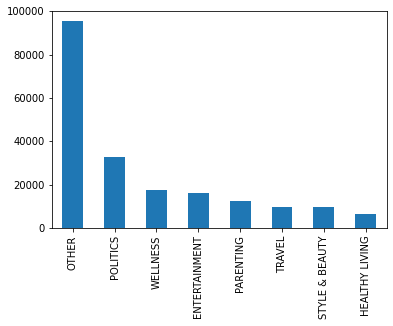

In [53]:
df_liquid_text2.category.value_counts().plot.bar()

In [54]:
train = df_liquid_text2[df_liquid_text2.id.isin(train_idx)]
test = df_liquid_text2[df_liquid_text2.id.isin(test_idx)]
print(train.shape)
print(test.shape)

(180762, 3)
(20086, 3)


In [55]:
if os.path.exists(filename):
    model_data = load(filename)
    search = model_data['model_CV']
else:
    search = GridSearchCV(text_clf_CV, param_grid, n_jobs=2)
    search.fit(train.text, train.category)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Best parameter (CV score=0.651):
{'tfidf__use_idf': True, 'vect__max_features': 10000}


In [56]:
descrete = 'tfidf__use_idf'
continuous = 'vect__max_features'
result_values = GridSearchResultToDF(search)    
PlotComparison(result_values, descrete, continuous)

alt.LayerChart(...)

In [57]:
text_clf = search.best_estimator_.fit(train['text'], train.category)
predicted_test = text_clf.predict(test['text'])
np.mean(predicted_test == test.category)

0.6824653987852235

In [58]:
if not os.path.exists(filename):
    model_dict = {
        'model_name': model_name,
        'model_description': model_description,
        'model_CV': search,
        'model_results': pd.concat([test[['id','category']],pd.DataFrame({'pred':predicted_test})])
    }
    dump(model_dict,filename)

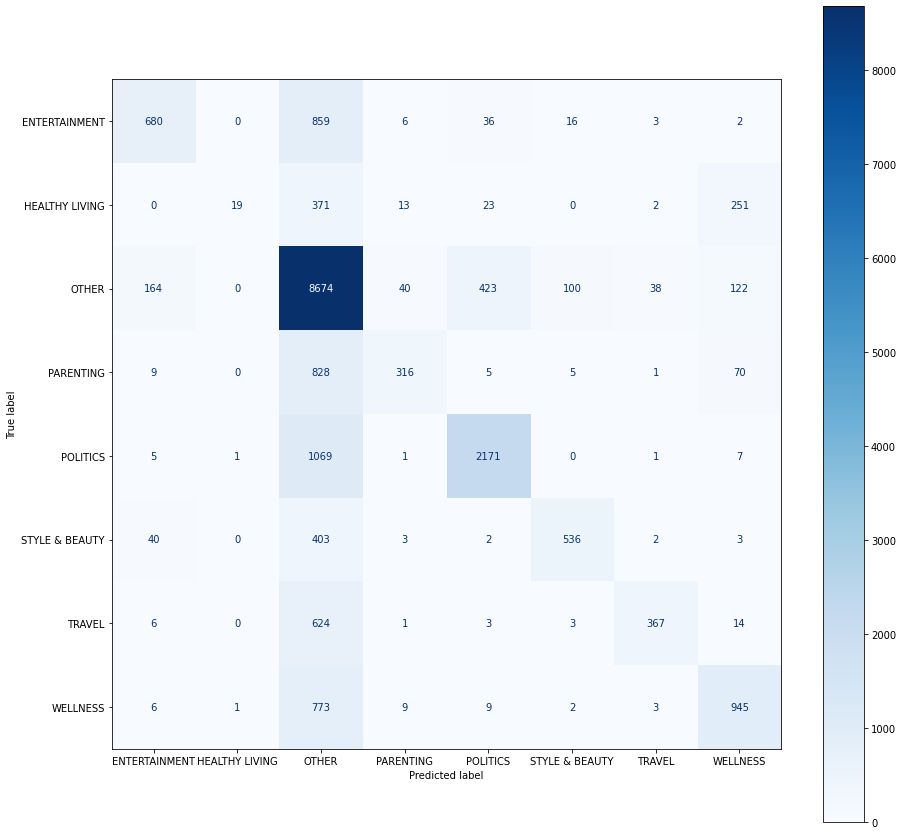

In [59]:
fig, ax = plt.subplots(figsize=(15, 15))
disp = plot_confusion_matrix(text_clf, test['text'], test.category,
                             cmap=plt.cm.Blues,
                             normalize=None,
                             ax = ax)

# Conclusions